In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import sys
# import tqdm
import torch

from torch.utils.tensorboard import SummaryWriter

from matplotlib          import rcParams
rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'font.size': 8})
plt.rcParams['figure.dpi'] = 150

## import own functions
sys.path.insert(1, '/lhome/silkem/MACE/MACE/src/mace')
import autoencoder  as ae
import dataset      as ds
import train        as tr
import neuralODE    as nODE

In [2]:
## Set up PyTorch 
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")
batch_size = 1 ## if not 1, dan kan er geen tensor van gemaakt worden
epochs = 1
lr = 0.01

kwargs = {'num_workers': 1, 'pin_memory': True} 

In [3]:
dirname = 'easy-mace2'
writer = SummaryWriter('runs/'+dirname)

train, data_loader, test_loader = ds.get_data(dirname = dirname, batch_size=batch_size, kwargs=kwargs, plot = True, scale = None)

Dataset:
------------------------------
total # of samples: 6626
# training samples: 4638
# testing samples:  1988
            ratio:  0.3


In [4]:
n_ex, p_ex, t_ex = next(iter(data_loader))
n_ex.shape, p_ex.type(), t_ex.shape
# n_ex

(torch.Size([1, 466, 12]), 'torch.FloatTensor', torch.Size([1, 12]))

In [5]:
model = nODE.Solver(p_dim=4,z_dim = 10, n_dim=466, DEVICE = DEVICE)
writer.add_graph(model, n_ex)
# writer.flush()
# model
# n_ex.shape



forward(__torch__.neuralODE.___torch_mangle_30.G self, Tensor z, Tensor p) -> Tensor:
Expected at most 3 arguments but found 4 positional arguments.
:
  File "/lhome/silkem/anaconda3/envs/mace/lib/python3.10/site-packages/torchode/terms.py", line 61
    
        if self.with_args:
            return self.f(t, y, args)
                   ~~~~~~ <--- HERE
        else:
            return self.f(t, y)
'ODETerm.vf' is being compiled since it was called from 'Dopri5.init'
  File "/lhome/silkem/anaconda3/envs/mace/lib/python3.10/site-packages/torchode/single_step_methods/runge_kutta.py", line 200
    
            if f0 is None:
                prev_vf1 = term_.vf(problem.t_start, problem.y0, stats, args)
                ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE
            else:
                prev_vf1 = f0

Error occurs, No graph saved


RuntimeError: 

forward(__torch__.neuralODE.___torch_mangle_30.G self, Tensor z, Tensor p) -> Tensor:
Expected at most 3 arguments but found 4 positional arguments.
:
  File "/lhome/silkem/anaconda3/envs/mace/lib/python3.10/site-packages/torchode/terms.py", line 61
    
        if self.with_args:
            return self.f(t, y, args)
                   ~~~~~~ <--- HERE
        else:
            return self.f(t, y)
'ODETerm.vf' is being compiled since it was called from 'Dopri5.init'
  File "/lhome/silkem/anaconda3/envs/mace/lib/python3.10/site-packages/torchode/single_step_methods/runge_kutta.py", line 200
    
            if f0 is None:
                prev_vf1 = term_.vf(problem.t_start, problem.y0, stats, args)
                ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE
            else:
                prev_vf1 = f0


In [6]:
writer.close()

In [11]:
## Training & validating model

loss_train_all, loss_test_all = tr.train(model, lr, data_loader, test_loader, epochs, DEVICE)
n_test, n_test_hat, loss = tr.test(model, test_loader, DEVICE)

Model:         
learning rate: 0.01

>>> Training model...
len tstep     torch.Size([1, 12])
stats         {'n_f_evals': tensor([584]), 'n_steps': tensor([97]), 'n_accepted': tensor([49]), 'n_initialized': tensor([5])}
status        tensor([4])
len tstep     torch.Size([1, 16])
stats         {'n_f_evals': tensor([710]), 'n_steps': tensor([118]), 'n_accepted': tensor([61]), 'n_initialized': tensor([7])}
status        tensor([4])
len tstep     torch.Size([1, 106])
stats         {'n_f_evals': tensor([764]), 'n_steps': tensor([127]), 'n_accepted': tensor([64]), 'n_initialized': tensor([5])}
status        tensor([4])
len tstep     torch.Size([1, 17])
stats         {'n_f_evals': tensor([650]), 'n_steps': tensor([108]), 'n_accepted': tensor([54]), 'n_initialized': tensor([3])}
status        tensor([4])

		# nan: 1 / 4638
len tstep     torch.Size([1, 15])
stats         {'n_f_evals': tensor([770]), 'n_steps': tensor([128]), 'n_accepted': tensor([64]), 'n_initialized': tensor([3])}
status       

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

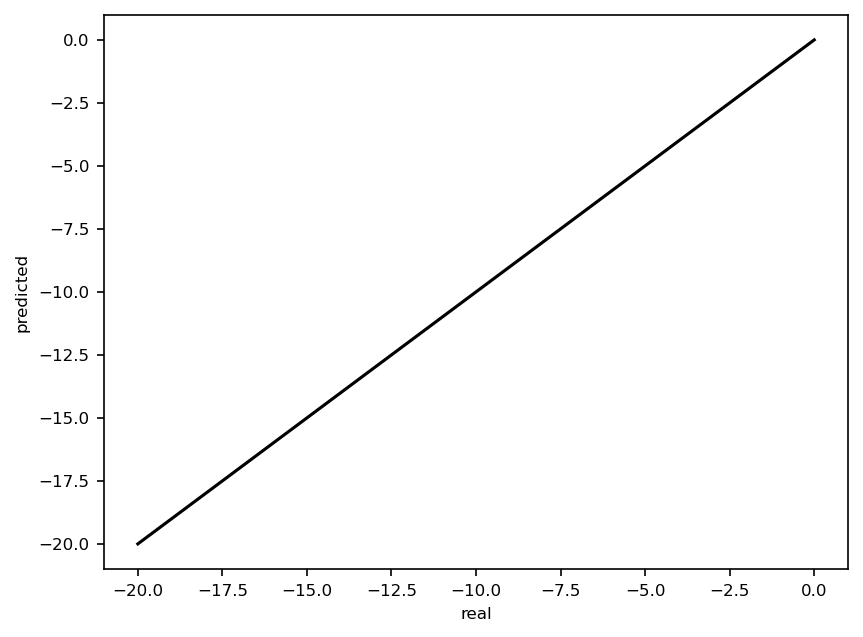

In [12]:
i = 0
x = np.linspace(-20,0,100)
print(n_test_hat[0][i])
print(n_test[0][i])
plt.plot(n_test[0][i],n_test_hat[0][i], 'o')
plt.plot(x,x,c='k')

plt.xlabel('real')
plt.ylabel('predicted')
plt.show()

### Testing seperately

In [5]:
enc = ae.Encoder( 466, 100, 10)
dec = ae.Decoder(10,100,466)

i = 849
n_test = train[i][0]
n_0    = n_test[:,0]
p      = train[i][1]
t      = train[i][2]

In [6]:
n_test[:,2]

tensor([0.7226, 0.3927, 0.2972, 0.2814, 0.4411, 1.0000, 0.3909, 0.1847, 0.0000,
        0.3325, 0.4542, 0.0000, 0.2347, 0.3718, 0.2282, 0.1601, 0.4799, 0.4442,
        0.5176, 0.4303, 0.1500, 0.4351, 0.0707, 0.1857, 0.2221, 0.0000, 0.4178,
        0.3992, 0.7526, 0.2610, 0.4209, 0.0862, 0.3999, 0.2976, 0.6599, 0.4695,
        0.7455, 0.1341, 0.1031, 0.4606, 0.0108, 0.6302, 0.0000, 0.3240, 0.0000,
        0.0000, 0.0499, 0.1694, 0.0000, 0.0000, 0.5708, 0.3528, 0.1794, 0.3846,
        0.4136, 0.8104, 0.3697, 0.3601, 0.1431, 0.8088, 0.3140, 0.5517, 0.2121,
        0.4686, 0.8083, 0.4103, 0.4241, 0.1747, 0.1962, 0.1324, 0.5893, 0.8770,
        0.1547, 0.6622, 0.5842, 0.4067, 0.3102, 0.3135, 0.5023, 0.2325, 0.1266,
        0.1393, 0.2994, 0.3860, 0.1142, 0.0000, 0.0000, 0.1667, 0.2551, 0.2968,
        0.1410, 0.1883, 0.2239, 0.2133, 0.1935, 0.2340, 0.1534, 0.0155, 0.1122,
        0.0891, 0.2008, 0.0000, 0.0000, 0.1519, 0.0000, 0.2442, 0.3596, 0.0000,
        0.1461, 0.0000, 0.0000, 0.0000, 

In [7]:
n_test.shape

torch.Size([466, 13])

In [16]:
z_0= enc(n_0)

z_0

tensor([ 0.0304, -0.0208,  0.0088,  0.0077,  0.1048,  0.0349,  0.0692,  0.0506,
         0.1116, -0.0181], grad_fn=<LeakyReluBackward0>)

In [17]:
g = nODE.G(4,10)
z = z_0.view(1,10)
g_fun = nODE.G.forward(g,t,z,p)
print(g_fun)

tensor([[0.0401, 0.0169, 0.0033, 0.0189, 0.0106, 0.0075, 0.0043, 0.0357, 0.0107,
         0.0334]], grad_fn=<AddBackward0>)


In [18]:
n_s = model(n_0, p, t.view(1,-1))
n_s

len tstep     torch.Size([1, 13])
stats         {'n_f_evals': tensor([668]), 'n_steps': tensor([111]), 'n_accepted': tensor([56]), 'n_initialized': tensor([5])}
status        tensor([4])


tensor([[[-0.0015,  0.0869, -0.0110,  ..., -0.0069,  0.0011,  0.0498],
         [-0.0015,  0.0872, -0.0110,  ..., -0.0069,  0.0012,  0.0498],
         [-0.0015,  0.0875, -0.0110,  ..., -0.0068,  0.0013,  0.0498],
         ...,
         [-0.0001,  0.0863, -0.0112,  ..., -0.0058,  0.0064,  0.0404],
         [-0.0001,  0.0863, -0.0112,  ..., -0.0058,  0.0064,  0.0404],
         [-0.0001,  0.0863, -0.0112,  ..., -0.0058,  0.0064,  0.0404]]],
       grad_fn=<ReshapeAliasBackward0>)

In [24]:
A = torch.rand(2,2).ravel()
B = torch.rand(2,2,2).ravel()
# print(A)

A = A.reshape(2,2)
B = B.reshape(2,2,2)

z = torch.rand(2)


torch.einsum("ij, j -> i", A, z) + torch.einsum("ijk, j, k -> i", B, z, z)

tensor([1.4498, 0.9794])